# F11116 v10

In [27]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import xarray as xr
import numpy as np
import pandas as pd
import rasterio
from matplotlib import pyplot as plt

src_path = Path('/u/duvel-d2/govorcin/NJ/ASC/disp_xr_tools/disp_xr_tools/src')
sys.path.append(str(src_path))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import logging
logger = logging.getLogger('disp_xr')

# Configure basic logging
logger.setLevel(logging.INFO)  # Set logging level

# Create handler (console output)
handler = logging.StreamHandler()
handler.setLevel(logging.INFO)  # Set level for this handler

# Add handler to logger
logger.addHandler(handler)

# Prevent duplicate logs if the root logger already has handlers
logger.propagate = False


In [29]:
import disp_xr
from disp_xr import product, stack as disp_stack, utils, quality_metrics, io
from disp_xr.mintpy_utils.utils import find_reference_point 
from pyproj import Transformer

In [115]:
def get_bounds(xr_data):
    x_min, x_max = xr_data.x.min().item(), xr_data.x.max().item()
    y_min, y_max = xr_data.y.min().item(), xr_data.y.max().item()
    return (x_min, x_max, y_min, y_max)

def construct_design_matrix(df):
    # Sort dataframe
    df = df.sort_values(by='date12')

    # Extract unique dates
    unique_dates = sorted(set(df['date1']).union(set(df['date2'])))
    date_index = {date: i for i, date in enumerate(unique_dates)}
    
    # Initialize design matrix (G)
    G = np.zeros((len(df), len(unique_dates)))
    
    # Populate G matrix
    for i, (_, row) in enumerate(df.iterrows()):
        G[i, date_index[row['date1']]] = -1
        G[i, date_index[row['date2']]] = 1
    
    return G, unique_dates

import matplotlib.patches as patches
def plot_chunk_location(ax, stack_xr: xr.Dataset, 
                        block:tuple, annot_txt:str, zorder:int=1):
    # Get coordinates 
    start_y = stack_xr.isel(y=block[1]).y.data[0]
    stop_y = stack_xr.isel(y=block[1]).y.data[-1]
    start_x = stack_xr.isel(x=block[2]).x.data[0]
    stop_x = stack_xr.isel(x=block[2]).x.data[-1]

    # Compute center of the rectangle
    center_x = (start_x + stop_x) / 2
    center_y = (start_y + stop_y) / 2

    # Create recangular
    rect = patches.Rectangle((start_x, start_y), 
                             stop_x - start_x, 
                             stop_y - start_y,
                             facecolor='none',
                             linewidth=1,
                             edgecolor='k',
                             zorder=zorder)
    
    # Plot 
    ax.add_patch(rect)

    # Annotate the center
    ax.text(center_x, center_y, str(annot_txt),
            ha="center", va="center", fontsize=8, zorder=zorder)   

In [31]:
# Get DISP version 0.10 data
disp_df = product.get_disp_info('/u/duvel-d0/ssangha/DISP_work/v10/F11116/products')

Found OPERA DISP: 314 products


Found OPERA DISP: 314 products
 Starting date: 2016-07-05 14:07:55
 Starting date: 2016-07-05 14:07:55
 Ending date: 2024-10-03 14:08:37
 Ending date: 2024-10-03 14:08:37
 Number of reference dates: 9
 Number of reference dates: 9
 Skip 0 duplicates
 Skip 0 duplicates


In [32]:
%%time
stack = disp_stack.combine_disp_product(disp_df)

Stacking ministack into common stack
Stacking ministack into common stack
 Chunk blocks: {'time': -1, 'x': 512, 'y': 512}
 Chunk blocks: {'time': -1, 'x': 512, 'y': 512}


CPU times: user 13.2 s, sys: 2.52 s, total: 15.7 s
Wall time: 2min 3s


In [33]:
# REchunk it for better analysis performance
# NOTE: if not rechunked to merge time dim, map_block will give wrong outputs
stack2 = stack.copy()
stack2 = stack2.chunk({'time':-1})

# Get chunks locations
chunks_ix = utils.get_chunks_indices(stack)
print(len(chunks_ix))

266


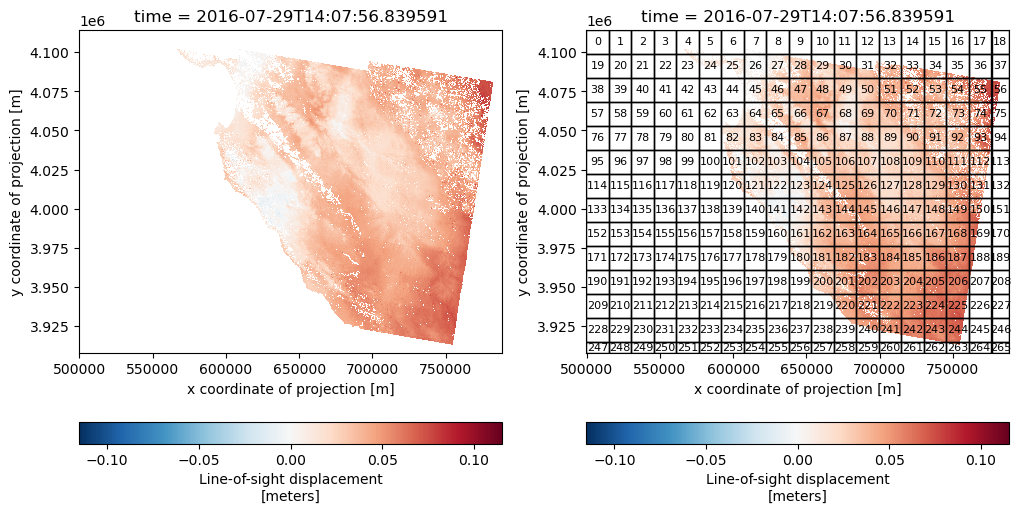

In [34]:
# Plot all chunks, take few min to plot chunk loc
# Skip this step if d
fig, ax = plt.subplots(1,2, figsize=(12,6))
cbar_kwargs={'orientation': 'horizontal'}

disp_epoch1_msk = stack.displacement.isel(time=0).where(stack.recommended_mask.isel(time=0)==1) 

disp_epoch1_msk.plot.imshow(ax=ax[0], cbar_kwargs=cbar_kwargs)
disp_epoch1_msk.plot.imshow(ax=ax[1], cbar_kwargs=cbar_kwargs)
for ix, block in enumerate(chunks_ix):
    plot_chunk_location(ax[1], stack, block, ix, zorder=1)

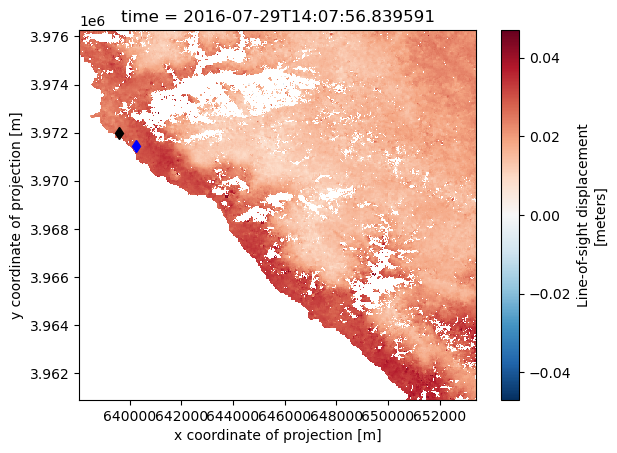

In [235]:
# Plot one chip for dev
fig, ax = plt.subplots()
ix =180 
mask = stack.recommended_mask[chunks_ix[ix]].isel(time=0)==1
stack.displacement[chunks_ix[ix]].isel(time=0).where(mask).plot.imshow(ax=ax)
ax.plot(stack2.displacement.sel(y=jump_y, x=jump_x, method='nearest').x,
        stack2.displacement.sel(y=jump_y, x=jump_x, method='nearest').y, 'kd')
ax.plot(stack2.displacement.sel(y=ref_y, x=ref_x, method='nearest').x,
        stack2.displacement.sel(y=ref_y, x=ref_x, method='nearest').y, 'bd')

In [36]:
with rasterio.open(f'NETCDF:"{str(disp_df.iloc[0].path)}":/displacement', 'r') as rd:
    crs = rd.crs
    gt = rd.transform.to_gdal()
    td = rd.transform 
    rows, cols = rd.shape


In [37]:
transformer = Transformer.from_crs(f'EPSG:{crs.to_epsg()}',
                                    "EPSG:4326",
                                    always_xy=True)

In [38]:
ref_y, ref_x = 3971445, 640245
jump_y, jump_x = 3971985, 639585

In [39]:
re_ref_data = stack2.displacement.sel(y=jump_y, x=jump_x, method='nearest') - stack2.displacement.sel(y=ref_y, x=ref_x, method='nearest') 

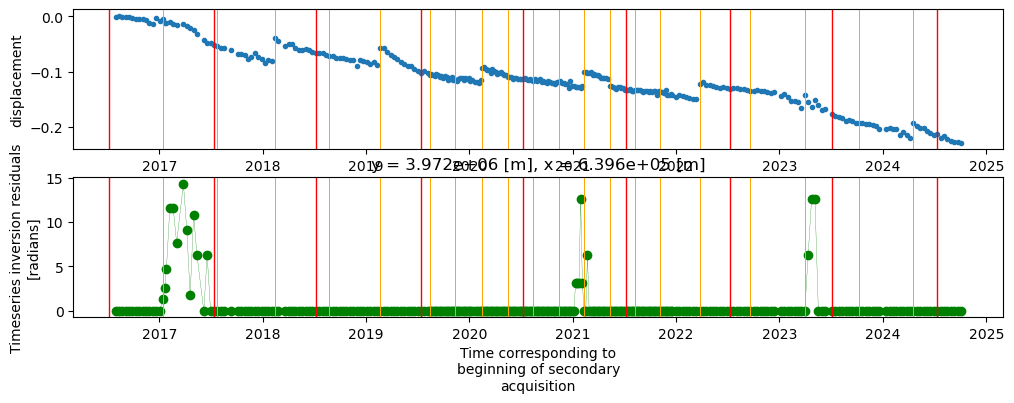

In [56]:
ref_dates = disp_xr.product._get_ministacks(disp_df)[1]
fig, ax = plt.subplots(2,1, figsize=(12,4))
re_ref_data.plot(ax=ax[0], marker='o', ms=3, lw=0)
for p in ref_dates: ax[0].axvline(pd.to_datetime(p, format='%Y%m%d'), color='r', lw=1)
for p in re_ref_data.time[14::15].values: ax[0].axvline(p, color='orange', lw=0.7) 

stack2.timeseries_inversion_residuals.sel(y=jump_y, x=jump_x, method='nearest').plot(ax=ax[1], marker='o', 
                                                                                     lw=0.2, color='green')
for p in ref_dates: ax[1].axvline(pd.to_datetime(p, format='%Y%m%d'), color='r', lw=1)
for p in re_ref_data.time[14::15].values: ax[1].axvline(p, color='orange', lw=0.7) 

In [76]:
disp2phase = 4 * np.pi / 0.0566 
wrap = lambda x: np.mod((4 *np.pi / 0.056 * x)+np.pi, 2*np.pi)-np.pi
wrap2pi = lambda x: np.mod((4 *np.pi / 0.056 * x), 2*np.pi)
dif_data = re_ref_data.diff(dim='time').values
dif_phase = dif_data * disp2phase

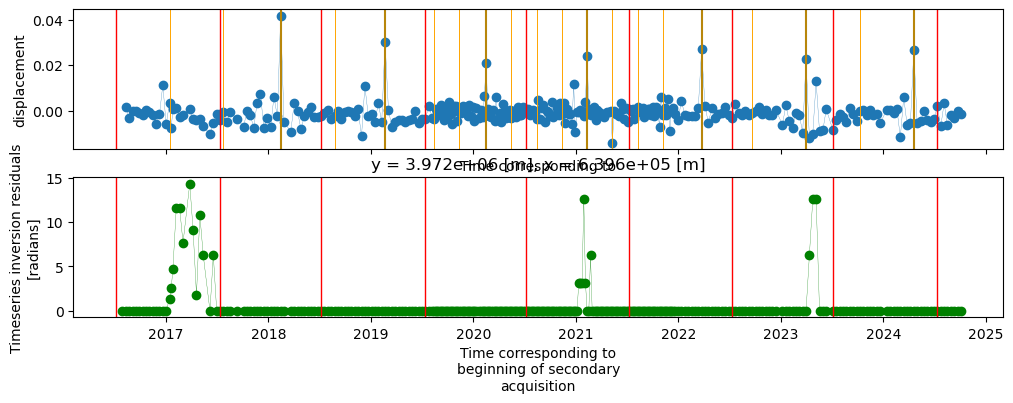

In [103]:
fig, ax = plt.subplots(2,1, figsize=(12,4), sharex=True)
re_ref_data.diff(dim='time', label='upper').plot(ax=ax[0], marker='o', lw=0.2)
for p in ref_dates: ax[0].axvline(pd.to_datetime(p, format='%Y%m%d'), color='r', lw=1)
for p in re_ref_data.time[14::15].values: ax[0].axvline(p, color='orange', lw=0.7)
for p in re_ref_data.time[14::15].values[[2, 4, 7, 11, 12, 15, 17, 19]]: ax[0].axvline(p, color='darkgoldenrod', lw=1.5)

stack2.timeseries_inversion_residuals.sel(y=jump_y, x=jump_x, method='nearest').plot(ax=ax[1], marker='o',
                                                                                     lw=0.2, color='green')
for p in ref_dates: ax[1].axvline(pd.to_datetime(p, format='%Y%m%d'), color='r', lw=1)

In [61]:
diff = re_ref_data.diff(dim='time', label='upper')

In [65]:
diff.sel(time=re_ref_data.time[14::15][3]).values

array(-0.0021553, dtype=float32)

Text(0, 0.5, 'radian')

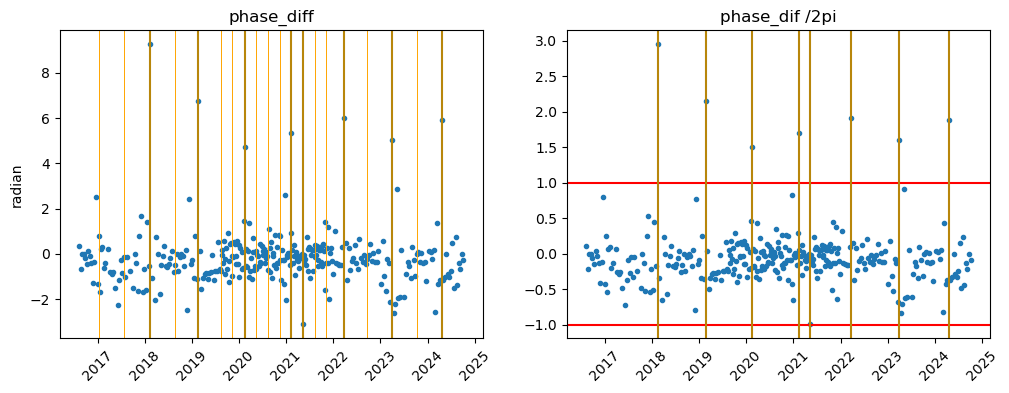

In [ ]:
dt = re_ref_data.diff(dim='time').time
fig, ax = plt.subplots(1,2, figsize=(12, 4))
for a, d in zip(ax, [dif_phase,
                     dif_phase / (2*np.pi)]):
    a.plot(dt, d, '.')
for p in re_ref_data.time[14::15].values: ax[0].axvline(p, color='orange', lw=0.7)
for p in re_ref_data.time[14::15].values[[2, 4, 7, 11, 12, 15, 17, 19]]: ax[0].axvline(p, color='darkgoldenrod', lw=1.5)

# Print color hline 2pi
ax[1].axhline(-1, color='red')
ax[1].axhline(-1+0.5, color='red', linestyle='dashed')
ax[1].axhline(-1-0.5, color='red', linestyle='dashed')
ax[1].axhline(1, color='red')
ax[1].axhline(1+0.5, color='red', linestyle='dashed')
ax[1].axhline(1-0.5, color='red', linestyle='dashed')
#for p in re_ref_data.time[14::15].values: ax[1].axvline(p, color='orange', lw=0.7)
for p in re_ref_data.time[14::15].values[[2, 4, 7, 11, 12, 15, 17, 19]]: ax[1].axvline(p, color='darkgoldenrod', lw=1.5)

for a, t in zip(ax, ['phase_diff', 'phase_dif /2pi']):
    a.set_title(t)
    a.tick_params(axis='x', rotation=45, labelsize=10)  # Rotate x-ticks

ax[0].set_ylabel('radian')

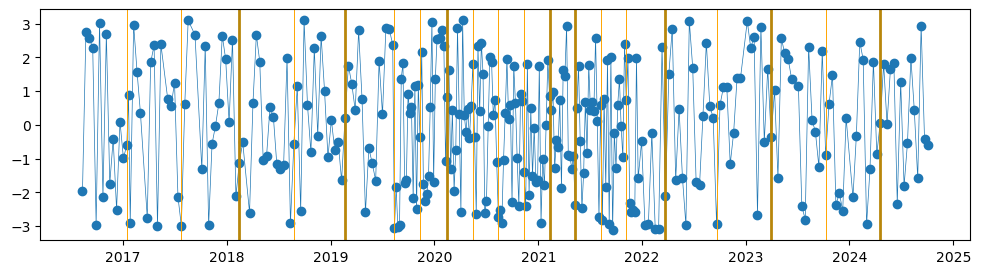

In [106]:
fig, ax = plt.subplots(1, figsize=(12,3))
ax.plot(dt, wrap(dif_phase),'-o', lw=0.5)
for p in re_ref_data.time[14::15].values: ax.axvline(p, color='orange', lw=0.7)
for p in re_ref_data.time[14::15].values[[2, 4, 7, 11, 12,15, 17, 19]]: ax.axvline(p, color='darkgoldenrod', lw=2)
   

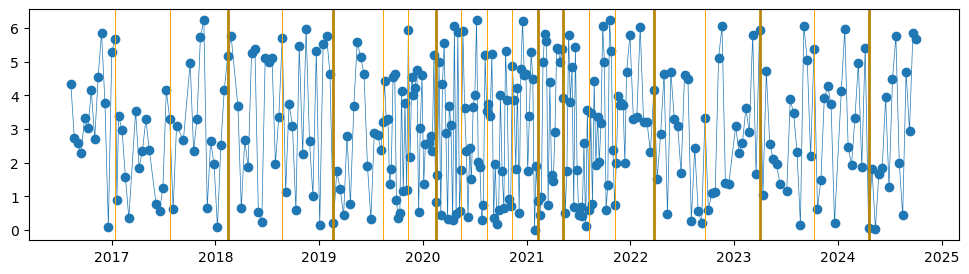

In [108]:
fig, ax = plt.subplots(1, figsize=(12,3))
ax.plot(dt, wrap2pi(dif_phase),'-o', lw=0.5)
for p in re_ref_data.time[14::15].values: ax.axvline(p, color='orange', lw=0.7)
for p in re_ref_data.time[14::15].values[[2, 4, 7, 11, 12, 15, 17, 19]]: ax.axvline(p, color='darkgoldenrod', lw=2) 

In [117]:
dates = construct_design_matrix(disp_df)[1]

In [120]:
compressed_slc_dates = dates[15::15]

In [124]:
pd.to_datetime(compressed_slc_dates[0])

Timestamp('2017-01-13 00:00:00')

In [232]:
def _detect_jump(data_xr, date:str):
    data = re_ref_data.time.sel(time=pd.to_datetime(date),
                     method='nearest')
    ix = re_ref_data.get_index('time').get_loc(data.values)
    data = (re_ref_data.isel(time=slice(ix-3, ix+3))*disp2phase).values
    return np.abs(np.diff([np.median(data[:3]), np.median(data[3:])])/np.pi) > 1


In [ ]:
for i, ministack_dt in enumerate(compressed_slc_dates):
    flag = _detect_jump(re_ref_data, ministack_dt)
    print(i, ':', flag)

In [217]:
data = re_ref_data.time.sel(time=pd.to_datetime(compressed_slc_dates[0]),
                     method='nearest')
ix = re_ref_data.get_index('time').get_loc(data.values)
data = (re_ref_data.isel(time=slice(ix-3, ix+3))*disp2phase).values
np.diff([np.median(data[:3]), np.median(data[3:])])

array([-0.7116426], dtype=float32)

In [229]:
np.rint(3.2 / np.pi)

1.0

In [218]:
data = re_ref_data.time.sel(time=pd.to_datetime(compressed_slc_dates[2]),
                            method='nearest')
ix = re_ref_data.get_index('time').get_loc(data.values)
data = (re_ref_data.isel(time=slice(ix-3, ix+3))*disp2phase).values
np.diff([np.median(data[:3]), np.median(data[3:])])

array([8.196701], dtype=float32)

In [221]:
data = re_ref_data.time.sel(time=pd.to_datetime(compressed_slc_dates[7]),
                             method='nearest')
ix = re_ref_data.get_index('time').get_loc(data.values)
data = (re_ref_data.isel(time=slice(ix-3, ix+3))*disp2phase).values
np.diff([np.median(data[:3]), np.median(data[3:])])

array([5.525446], dtype=float32)

In [220]:
data = re_ref_data.time.sel(time=pd.to_datetime(compressed_slc_dates[11]),
                             method='nearest')
ix = re_ref_data.get_index('time').get_loc(data.values)
data = (re_ref_data.isel(time=slice(ix-3, ix+3))*disp2phase).values
np.diff([np.median(data[:3]), np.median(data[3:])])

array([5.752428], dtype=float32)

In [219]:
data = re_ref_data.time.sel(time=pd.to_datetime(compressed_slc_dates[12]),
                             method='nearest')
ix = re_ref_data.get_index('time').get_loc(data.values)
data = (re_ref_data.isel(time=slice(ix-3, ix+3))*disp2phase).values
np.diff([np.median(data[:3]), np.median(data[3:])])

array([-3.204403], dtype=float32)

In [224]:
data = re_ref_data.time.sel(time=pd.to_datetime(compressed_slc_dates[12]),
                             method='nearest')
ix = re_ref_data.get_index('time').get_loc(data.values)
data = (re_ref_data.isel(time=slice(ix-3, ix+3)).diff('time')*disp2phase).values

In [227]:
data

array([-0.08977582, -0.03207792, -3.118545  , -0.05378079, -0.3002408 ],
      dtype=float32)

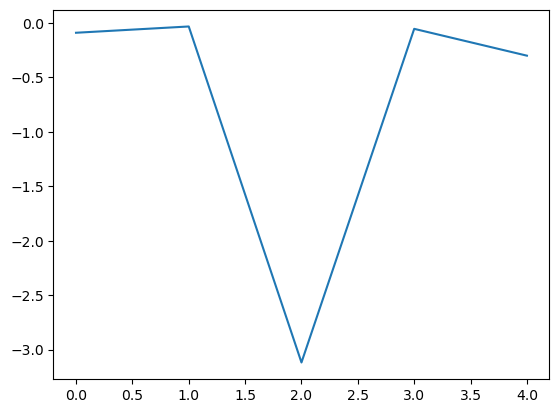

In [226]:
plt.plot(data)

In [188]:
np.rint(data / (np.pi))

array([-0., -0., -1., -0., -0.], dtype=float32)